In [1]:
# %load ../text_lord/handlers/bulk_text.py
import os
from pathlib import Path
from logging import getLogger

logger = getLogger(__name__)


def get_files_path(dir_path, pattern='**/*.txt'):
    paths = []
    pathlist = Path(dir_path).glob(pattern)
    for path in pathlist:
        paths.append(str(path))
    return paths


def read_file_text(filename, encoding='utf-8'):
    text = ''
    with open(filename, 'r', encoding=encoding) as f:
        try:
            text = f.read()
        except UnicodeDecodeError:
            logger.warning('Can\'t read file {0}. Bad encoding.'
                           .format(filename))
    return text


def loadAll(dir_path):
    text = ''
    for filename in get_files_path(dir_path):
        text = text + read_file_text(filename)
    return text


def load(dir_path):
    texts = {}
    for filename in get_files_path(dir_path):
        texts[filename] = read_file_text(filename)
    logger.debug('Total texts count: {0}'.format(len(texts)))
    return texts


def save(path, text, encoding='utf-8'):
    dirs, filename = os.path.split(path)
    os.makedirs(dirs, exist_ok=True)
    with open(path, 'w', encoding=encoding) as f:
        f.write(text)


def rename_paths(paths, *patterns):
    new_paths = []
    for path in paths:
        for old, new in patterns:
            new_paths.append(path.replace(old, new))
    return new_paths

In [2]:
texts = load('../datasets/bbc/tennis')

In [3]:
# %load ../text_lord/algorithms/vsm/tfidf.py
import string
from collections import Counter
import math


def remove_punct(s):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s


def get_stop_words(fin):
    return set([term.strip() for term in fin])


def remove_stop_words(d, stopwords):
    for term in set(d.keys()):
        if term in stopwords:
            del d[term]


def count_term_frequencies(text):
    tf = Counter()
    tf.update(map(lambda x: remove_punct(x.lower()), text.split()))
    return tf


def count_all_frequencies(term_frequencies):
    df = Counter()
    for path, tf in term_frequencies.items():
        df.update(tf.keys())
    return df


def get_document_frequency(all_frequencies, term):
    if term in all_frequencies:
        return all_frequencies[term] + 1
    else:
        return 1


# ========== TF-IDF ==========

def tfidf(tf, df, dc):
    return tf * math.log(float(dc) / df)


def tfidf_by_doc(term_frequencies, all_frequencies, doc_count):
    tf_idf = {}
    for doc_id, term_freq in term_frequencies.items():
        for term, frequency in term_freq.items():
            doc_frequency = get_document_frequency(all_frequencies, term)
            term_score = tfidf(frequency, doc_frequency, doc_count)
            if doc_id not in tf_idf:
                tf_idf[doc_id] = {}
            tf_idf[doc_id].update({term: term_score})
    return tf_idf


def get_TFIDF_scores(texts):
    term_frequencies_by_doc = {path: count_term_frequencies(text)
                               for path, text in texts.items()}
    all_frequencies = count_all_frequencies(term_frequencies_by_doc)
    doc_count = len(texts)
    tfidf_scores = tfidf_by_doc(term_frequencies_by_doc, all_frequencies,
                                doc_count)
    return tfidf_scores

In [4]:
tfidf_scores = get_TFIDF_scores(texts)

In [5]:
tfidf_scores

{'../datasets/bbc/tennis/001.txt': {'': 3.566392477135134,
  '16': 2.120263536200091,
  '40': 5.991464547107982,
  '46': 6.120662485579664,
  '53': 3.2188758248682006,
  '64': 1.1394342831883648,
  '65': 3.506557897319982,
  '76': 1.0498221244986776,
  '86': 2.207274913189721,
  'a': 0.0,
  'admitted': 1.7719568419318754,
  'after': 0.9441322345191006,
  'afterwards': 2.407945608651872,
  'against': 1.5530575789979926,
  'aggressively': 3.912023005428146,
  'ago': 2.302585092994046,
  'alarms': 3.912023005428146,
  'and': 0.07035235097451054,
  'andreev': 3.506557897319982,
  'are': 1.2378743560016172,
  'as': 2.464744557695268,
  'at': 1.0700248318161971,
  'back': 0.9942522733438669,
  'because': 1.1086626245216111,
  'before': 1.0498221244986776,
  'between': 2.407945608651872,
  'body': 2.659260036932778,
  'both': 1.7147984280919266,
  'break': 1.9661128563728327,
  'british': 3.6651629274966204,
  'broke': 1.8325814637483102,
  'but': 0.2785241346670152,
  'by': 2.265067752834098

In [6]:
# sorted(tfidf_scores.items(), key=lambda x: x[1])
from collections import OrderedDict
import operator
# sorted(tfidf_scores.values(), key=lambda t: )
# [operator.itemgetter(v) for v in tfidf_scores.values()]
sor = {}
for id, doc in tfidf_scores.items():
    sorted_x = sorted(doc.items(), key=operator.itemgetter(1), reverse=True)
    sor.update({id: sorted_x})
sorted(sor.items(), key=lambda x: x[1][0][1], reverse=True)

[('../datasets/bbc/tennis/071.txt',
  [('nadal', 86.93080498420373),
   ('roddick', 65.64735235944671),
   ('point', 29.893161722789717),
   ('break', 29.491692845592492),
   ('holds', 27.38416103799702),
   ('saves', 27.38416103799702),
   ('hold', 26.961590461985917),
   ('roddicks', 24.54590528123987),
   ('serve', 23.514815520943067),
   ('winner', 20.402208285265544),
   ('manages', 19.56011502714073),
   ('nadals', 19.56011502714073),
   ('volley', 19.313254949209202),
   ('spaniard', 16.11809565095832),
   ('serves', 15.648092021712584),
   ('net', 14.978661367769954),
   ('ace', 14.978661367769954),
   ('crowd', 14.44767365191123),
   ('forehand', 14.026231589279927),
   ('disappointment', 14.026231589279927),
   ('crosscourt', 14.026231589279927),
   ('game', 13.977518210981934),
   ('service', 12.721581217200546),
   ('points', 12.403697893523129),
   ('doublefaults', 11.736069016284437),
   ('produces', 11.736069016284437),
   ('score', 11.736069016284437),
   ('passing', 11

In [7]:
from nltk import tokenize
import string

def remove_punct(s):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s

# sentences = []

# for path, text in texts.items():
sentences = tokenize.sent_tokenize(next (iter (texts.values())))
result = []
for i in range(0, len(sentences)):
    words = sentences[i].split()
    cur_sentence = []
    for word in words:
        formated = remove_punct(word.lower())
        if len(cur_sentence) < 15:
            cur_sentence.append(formated)
    result.append(cur_sentence)
# sentences.append(cur_sentence)
# sentences

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import table

# data = pd.Series(result)
# the_table = plt.table(cellText=result)
# plt.plot()
r = result[0:10]
data = pd.DataFrame(r)
# data.head()

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, data)  # where df is your data frame

# plt.savefig('mytable.png')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,davenport,puts,retirement,on,hold,lindsay,davenport,has,put,any,talk,of,retirement,on,hold
1,the,28yearold,world,number,one,had,said,that,she,would,quit,at,the,end,of
2,finally,i,felt,i,put,myself,in,a,position,to,try,and,win,grand,slams
3,it,would,be,tough,to,walk,away,when,i,feel,like,i,can,contend,so
4,davenport,has,won,three,grand,slams,the,2000,australian,open,wimbledon,in,1999,and,the


In [9]:
df = pd.DataFrame(tfidf_scores)

In [10]:
df.head()

,../datasets/bbc/tennis/001.txt,../datasets/bbc/tennis/002.txt,../datasets/bbc/tennis/003.txt,../datasets/bbc/tennis/004.txt,../datasets/bbc/tennis/005.txt,../datasets/bbc/tennis/006.txt,../datasets/bbc/tennis/007.txt,../datasets/bbc/tennis/008.txt,../datasets/bbc/tennis/009.txt,../datasets/bbc/tennis/010.txt,...,../datasets/bbc/tennis/091.txt,../datasets/bbc/tennis/092.txt,../datasets/bbc/tennis/093.txt,../datasets/bbc/tennis/094.txt,../datasets/bbc/tennis/095.txt,../datasets/bbc/tennis/096.txt,../datasets/bbc/tennis/097.txt,../datasets/bbc/tennis/098.txt,../datasets/bbc/tennis/099.txt,../datasets/bbc/tennis/100.txt
,3.566392,NaN,NaN,NaN,0.891598,1.783196,NaN,NaN,NaN,NaN,...,NaN,NaN,0.891598,NaN,2.674794,1.783196,NaN,NaN,NaN,NaN
02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
030,NaN,NaN,NaN,NaN,3.218876,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
filtered = {}
i = 0
prev_id = ''
for doc_id, doc in tfidf_scores.items():
    if i > 5:
        break
    if doc_id not in filtered:
        filtered[doc_id] = {}
    for word, score in doc.items():
        if len(filtered) == 1:
            filtered[doc_id].update({word: score})
        elif word in filtered[prev_id]:
            filtered[doc_id].update({word: score})
    prev_id = doc_id
    i = i + 1
filtered

{'../datasets/bbc/tennis/027.txt': {'a': 0.0,
  'after': 0.3147107448397002,
  'and': 0.040201343414006024,
  'at': 0.3566749439387324,
  'australian': 1.346689106527531,
  'be': 0.47803580094299974,
  'but': 0.4177862020005228,
  'hit': 1.9661128563728327,
  'i': 0.697413548579111,
  'in': -0.07960264682534474,
  'it': 0.6849806178935518,
  'like': 1.2039728043259361,
  'no': 1.3470736479666094,
  'number': 0.5798184952529422,
  'of': 0.18182436585767522,
  'on': 0.25566674301977,
  'open': 0.5753641449035617,
  'said': 0.166763217878102,
  'so': 1.07880966137193,
  'that': 1.156987442435954,
  'the': -0.2388079404760342,
  'to': 0.0,
  'top': 0.8209805520698303,
  'up': 0.6348782724359695,
  'was': 0.8355724040010456,
  'when': 1.9046348173079086,
  'wimbledon': 1.2378743560016172,
  'win': 1.5324768712979722},
 '../datasets/bbc/tennis/029.txt': {'a': 0.0,
  'after': 0.3147107448397002,
  'and': 0.10050335853501506,
  'at': 0.3566749439387324,
  'but': 0.5570482693340304,
  'i': 0.34

In [12]:
filtered.pop('../datasets/bbc/tennis/009.txt', None)

In [13]:
df = pd.DataFrame(filtered)
df.head(10)

,../datasets/bbc/tennis/027.txt,../datasets/bbc/tennis/029.txt,../datasets/bbc/tennis/038.txt,../datasets/bbc/tennis/040.txt,../datasets/bbc/tennis/059.txt,../datasets/bbc/tennis/060.txt
1998,NaN,NaN,NaN,2.525729,NaN,NaN
1999,NaN,NaN,NaN,3.218876,NaN,NaN
2000,NaN,NaN,NaN,2.302585,NaN,NaN
2004,NaN,NaN,NaN,1.897120,NaN,1.897120
28yearold,NaN,NaN,NaN,3.506558,NaN,NaN
a,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
able,NaN,NaN,NaN,2.120264,NaN,NaN
after,0.314711,0.314711,0.314711,0.629421,NaN,0.944132
again,NaN,NaN,NaN,1.272966,NaN,NaN
all,NaN,NaN,NaN,0.843970,NaN,0.843970


In [14]:
sentences = {}
for path, text in texts.items():
    cur_sent = tokenize.sent_tokenize(text)
    sentences.update({path: len(cur_sent)})
sentences
sents = sorted(sentences.items(), key=operator.itemgetter(1), reverse=True)

In [15]:
df = pd.DataFrame(sents, columns=['Документ', 'Количество предложений'])
df.head(10)

,Документ,Количество предложений
0,../datasets/bbc/tennis/071.txt,81
1,../datasets/bbc/tennis/073.txt,37
2,../datasets/bbc/tennis/069.txt,30
3,../datasets/bbc/tennis/070.txt,30
4,../datasets/bbc/tennis/075.txt,30
5,../datasets/bbc/tennis/026.txt,30
6,../datasets/bbc/tennis/053.txt,28
7,../datasets/bbc/tennis/029.txt,27
8,../datasets/bbc/tennis/054.txt,27
9,../datasets/bbc/tennis/050.txt,27


In [16]:
# %load ../text_lord/algorithms/utils/utils.py
import string
import os
import sys
from nltk import tokenize
import codecs


# reload(sys)
# sys.setdefaultencoding("utf-8")


def removePunct(s):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s


# def getSentences(doc_dir, doc_id):
#     i = 0
#     for subdir, dirs, files in os.walk(doc_dir):
#         files.sort()
#         for file in files:
#             filepath = subdir + file
#             if i == doc_id:
#                 with open(filepath) as doc:
#                     sentences = tokenize.sent_tokenize(doc.read())
#                     return sentences
#
#             else:
#                 i = i + 1

def getSentences(paths, doc_id):
    filepath = paths[doc_id]
    with open(filepath) as doc:
        sentences = tokenize.sent_tokenize(doc.read())
        return sentences


def get_sentences(text):
    return tokenize.sent_tokenize(text)


def mapTFIDFScores(sentence, scores):
    words = sentence.split()
    mapping = dict((w, scores[removePunct(w.lower())]) for w in words)
    return mapping


def map_TFIDF_scores(sentence, scores):
    mapping = {}
    words = sentence.split()
    for word in words:
        formated = removePunct(word.lower())
        score = scores[formated]
        mapping[formated] = score
    return mapping


In [46]:
# %load ../text_lord/algorithms/lexrank/lexrank.py
import numpy as np
import math


class LexRank(object):
    def __init__(self, texts):
        self.texts = texts
        self.tfidf_scores = get_TFIDF_scores(texts)
        self.matrix = []
        self.sentences = []

    def summarization(self, similarity_func, normalize_func):
        matrices = []
        sentences = []
        for path, text in self.texts.items():
            curr_sentences = get_sentences(text)
            curr_num_of_sentences = len(curr_sentences)
            sentences.append(curr_sentences)
            matrices.append(self.build_similarity_matrix(curr_num_of_sentences,
                                                         curr_sentences, path,
                                                         similarity_func,
                                                         normalize_func))
        self.matrix = matrices
        self.sentences = sentences

    def build_similarity_matrix(self, num_of_sentences, sentences, doc_id,
                                similarity_func, normalize_func):
        matrix = np.zeros(shape=(num_of_sentences, num_of_sentences))
        for x in range(0, num_of_sentences):
            vec_x = map_TFIDF_scores(sentences[x],
                                           self.tfidf_scores[doc_id])
            for y in range(0, num_of_sentences):
                if x == y:
                    matrix[x][y] = 1.0
                    continue
                vec_y = map_TFIDF_scores(sentences[y],
                                               self.tfidf_scores[doc_id])
                score = similarity_func(vec_x, vec_y)
                if np.isnan(score):
                    score = 0.0
                matrix[x][y] = score

        # Normalize each row of scores
        for x in range(0, num_of_sentences):
            matrix[x] = normalize_func(matrix[x], num_of_sentences)
        return matrix

    def rank(self, similarity_threshold, epsilon, iterations, continuous,
             damp):
        return multi_doc_rank(self.matrix, self.sentences,
                              similarity_threshold, epsilon, iterations,
                              continuous, damp)


def multi_doc_rank(matrices, sentences, similarity_threshold, epsilon,
                   iterations, continuous, damp):
    rankings = []
    for x in range(0, len(matrices)):
        num_of_sentences = len(matrices[x][0])
        similarity_matrix = reflect_over_YX(matrices[x], num_of_sentences)
        transition_matrix = build_transition_matrix(similarity_matrix,
                                                    num_of_sentences,
                                                    similarity_threshold,
                                                    continuous)
        rank, score = power_iteration(transition_matrix, num_of_sentences,
                                      epsilon, iterations, damp)
        rankings.append(rank)
    return rankings, sentences


# Reflect Scores of the matrix over the line y = x b/c index order of
# sentence doesn't matter
def reflect_over_YX(matrix, num_of_sentences):
    result = np.zeros((num_of_sentences, num_of_sentences))
    for x in range(0, num_of_sentences):
        for y in range(0, x + 1):
            result[x][y] = result[y][x] = matrix[x][y]
    return result


# Build transition probability matrix with threshold | continuous
def build_transition_matrix(similarity_matrix, num_of_sentences,
                            similarity_threshold=.1, continuous=True):
    transition_matrix = np.zeros((num_of_sentences, num_of_sentences))
    for x in range(0, num_of_sentences):
        degree = 0
        for y in range(0, num_of_sentences):
            if similarity_matrix[x][y] > similarity_threshold:
                if continuous:
                    transition_matrix[x][y] = similarity_matrix[x][y]
                    degree += similarity_matrix[x][y]
                else:
                    transition_matrix[x][y] = 1
                    degree += 1
        for y in range(0, num_of_sentences):
            transition_matrix[x][y] /= degree

    return transition_matrix


def power_iteration(stochastic_matrix, num_of_sentences, epsilon, max_iterations,
                    damp):
    if damp > 0:
        curr_matrix = apply_damping_factor(stochastic_matrix, num_of_sentences,
                                           damp).transpose()
    else:
        curr_matrix = stochastic_matrix.transpose()
    curr_vec = np.zeros((num_of_sentences, 1))
    prev_vec = np.zeros((num_of_sentences, 1))
    curr_vec.fill(1.0 / num_of_sentences)

    for x in range(0, max_iterations):
        prev_vec = curr_vec
        curr_vec = np.dot(curr_matrix, curr_vec)
        error = 0.0
        for y in range(0, num_of_sentences):
            error += math.sqrt(abs(curr_vec[y][0] - prev_vec[y][0]))
        if error < math.sqrt(epsilon):
            break

    # Scores sorted from lowest to biggest
    scores = [curr_vec[x][0] for x in range(0, num_of_sentences)]

    # Ranking based on biggest score to lowest so indexes are reversed
    rankings = np.argsort(scores)
    rankings = rankings[::-1]
    return rankings, scores


def apply_damping_factor(matrix, N, d):
    # 1-dB
    matrix = np.multiply(matrix, 1 - d)
    dU = np.zeros((N, N))
    dU.fill(1.0 / N)
    return dU + matrix


In [47]:
import math


def cosine(d1, d2):
    numerator = 0
    denominator1 = 0
    denominator2 = 0

    for (k, v) in d1.items():
        denominator1 += v ** 2
        if k in d2:
            numerator += v * d2[k]

    for (k, v) in d2.items():
        denominator2 += v ** 2

    return 1 - (numerator / (math.sqrt(denominator1) * math.sqrt(denominator2)))

# Normalize the vector input:vector,length of vector   output:normalized vector
def normalize_by_length(array, length):
    dist = 0
    for x in range(0, length):
        dist += array[x] * array[x]

    dist = math.sqrt(dist)

    for x in range(0, length):
        array[x] = array[x] / dist

    return array

In [48]:
lr = LexRank(texts)
lr.summarization(cosine, normalize_by_length)
rankings, sentences = lr.rank(0.1, 0.005, 100, True, 0.15)

In [49]:
df = pd.DataFrame(rankings)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,3,0,5,6,4,7,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,16,9,17,21,11.0,20.0,6.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,4,3,11,6,10,14.0,13.0,15.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,1,8,2,11,0.0,9.0,10.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3,5,4,0,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,11,8,4,6,9,10.0,5.0,7.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,3,9,7,14,5,15.0,18.0,12.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,5,4,3,2,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,3,7,6,5,4,0.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,9,10,7,4,13,12.0,8.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
rankings

[array([3, 0, 5, 6, 4, 7, 1, 2]),
 array([ 1,  2, 16,  9, 17, 21, 11, 20,  6, 14, 15,  3, 19, 18,  0, 24,  8,
        10,  7,  4, 13, 23, 22,  5, 12, 25]),
 array([ 8,  4,  3, 11,  6, 10, 14, 13, 15, 12,  7,  9,  5,  0,  1,  2]),
 array([ 4,  3,  1,  8,  2, 11,  0,  9, 10,  7,  5,  6]),
 array([1, 3, 5, 4, 0, 2]),
 array([ 1, 11,  8,  4,  6,  9, 10,  5,  7,  2,  3,  0]),
 array([ 6,  3,  9,  7, 14,  5, 15, 18, 12, 16, 13, 17, 10, 11,  4,  8,  1,
         0,  2]),
 array([1, 5, 4, 3, 2, 0]),
 array([1, 3, 7, 6, 5, 4, 0, 2]),
 array([ 1,  9, 10,  7,  4, 13, 12,  8,  2,  3,  5, 11,  6,  0]),
 array([ 4,  9, 13, 11, 14, 15, 16, 18, 17, 12, 10,  5,  3,  6,  1,  0,  2,
         7,  8]),
 array([ 1,  7,  5,  3, 14, 13, 15,  8, 11, 12,  9, 10,  4,  2,  6,  0]),
 array([6, 2, 4, 5, 7, 3, 1, 0]),
 array([8, 7, 4, 3, 6, 9, 5, 1, 2, 0]),
 array([ 3,  1, 15,  2, 12,  7, 16,  8, 13,  5,  9, 14, 19, 17, 20, 18, 21,
        10,  0, 11,  4,  6]),
 array([11, 10,  9, 16,  2, 14, 15,  6, 13, 12,  7,  1, 

In [51]:
sentences[2][7]

'Mirza, a junior Wimbledon doubles title winner, became the first Indian woman to reach the third round of a grand slam tennis event when she beat Hungarian Petra Mandula on Wednesday.'

In [54]:
lr.matrix

[array([[ 0.38922872,  0.38048533,  0.22105812,  0.38922872,  0.23420969,
          0.38148372,  0.38922872,  0.38920847],
        [ 0.39761325,  0.40675023,  0.40654557,  0.38275272,  0.39586307,
          0.22761092,  0.28633723,  0.27235216],
        [ 0.22475235,  0.39553422,  0.39573334,  0.39300664,  0.1177191 ,
          0.39573046,  0.39572651,  0.39359892],
        [ 0.35758235,  0.33648566,  0.35511852,  0.35758235,  0.35757401,
          0.35758235,  0.35757496,  0.34835873],
        [ 0.23974713,  0.38776679,  0.11852166,  0.39842199,  0.39843129,
          0.37834078,  0.39842411,  0.39842157],
        [ 0.39737464,  0.226879  ,  0.40543931,  0.40544226,  0.38499823,
          0.40544226,  0.27408987,  0.27225453],
        [ 0.40449598,  0.28475032,  0.404489  ,  0.40448762,  0.40448869,
          0.27345016,  0.40449598,  0.16147935],
        [ 0.40833643,  0.27342847,  0.40615516,  0.39782433,  0.40834771,
          0.27421223,  0.16302098,  0.40835767]]),
 array([[ 0.20

In [67]:
import networkx as nx

X = np.array(lr.matrix[4])
X.shape
g = nx.from_numpy_matrix(X)

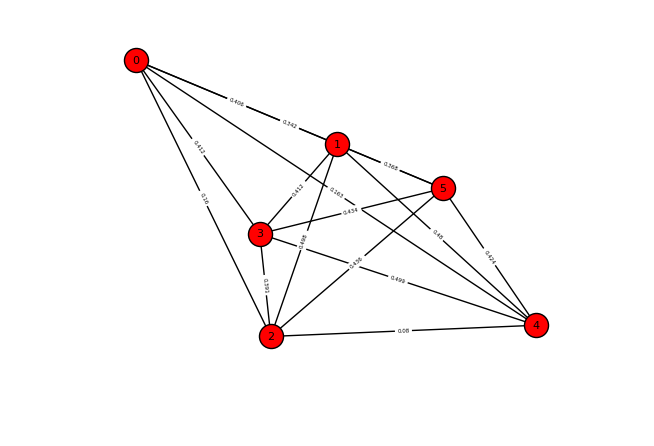

In [68]:
# pos=nx.get_node_attributes(g, 'pos')
pos=nx.spring_layout(g, scale=20)
nx.draw(g, pos)
w_labels = nx.get_edge_attributes(g, 'weight')
w_labels = dict((node, round(weight, 3)) for node, weight in w_labels.items())
# print(w_labels)
# get_node_attributes
nx.draw_networkx_labels(g, pos, font_size=8)
nx.draw_networkx_edge_labels(g, pos, edge_labels=w_labels, font_size=4)
plt.show()